# Qiskit X PyTorch - The Ultimate Collab

How can we improve machine learning algorithms is a question many are trying to solve. Research is advancing by involving various areas, but the integration of quantum computing and machine learning is a promising area of research - Quantum Machine Learning.

It is flexible. Whether we want to enhance classical ML algorithms by outsourcing difficult calculation to a Quantum Computer, or to optimise quantum algorithms using classical ML architectures - QML has got you covered. The possibilities are limitless.   

In [1]:
! pip install qiskit

  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.4/240.4 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.8/943.8 kB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 57.5 MB/s eta 0:00:00
  Created wheel for qiskit: filename=qiskit-0.39.2-py3-none-any.whl size=12226 sha256=373ed9353cc0af4ab82ed01212af85a9f4ecd6d7d44c6385efc92b20a18eef07
  Stored in directory: /root/.cache/pip/wheels/30/dc/90/0ee55ccffd13c16db1abd4c43028f7c9cedb5576b190402190
Successfully built qiskit


## Hybrid Quantum Classical Neural Network

A neural network is basically an easy to compute, non-linear function that is built by composing smaller building blocks(neurons). The output from a neuron is fed to other neurons. Weights are associated with inputs to a neuron. The overall objective is choosing our weights such that the network behaves in a particular way.

That's all fair and good, **but how does quantum enters the picture** ?

To create a quantum-classical neural network, one can implement a hidden layer for our neural network using a parameterized quantum circuit(a circuit whose rotation angle for each gate are specified by the components of a classical input vector). The following image demonstrates what we are trying to achieve with Hybrid Quantum-Classical Neural Network.

![Image Courtesy of Qiskit](https://qiskit.org/textbook/ch-machine-learning/neuralnetworkQC.png)


## Problems and Intuitive Solutions

- Backpropagation : For classical neural networks, this is not a problem. But for PQC gradients are a little tricky to find. Without going into too much detail, there is some thing called parameter shift rule which is used for calculating the gradient of a PQC.

- Circuit Construction : This is creative part. Try different things and see how they affect the model. Go Bananas, but use the scientific method.

In [2]:
## Imports 
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Function
from torchvision import datasets, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import * 

import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


Using device: cpu


### QuantumCircuit Class - Qiskit Functions and Data

It is much easier(and easy to experiment with) if we bundle all the data and function associated with Qiskit in `QuantumCircuit` class. Experiment with different PQC and try to come up with elaborate and creative schemes for Quantum-Classical Networks.

In [3]:
class QuantumCircuit:
    def __init__(self, n_qubits, backend, shots):
        
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        self.theta = qiskit.circuit.Parameter('theta')
        all_qubits = [i for i in range(n_qubits)]
        
        # Unleash your creativity here - use different circuits and schemes. Go bananas !
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)

        self._circuit.measure_all()
        
        self.backend = backend
        self.shots = shots
        
    def run(self, thetas):
        t_qc = transpile(self._circuit, self.backend)
        q_obj = assemble(t_qc, 
                         shots = self.shots,
                         parameter_binds = [{self.theta : theta} for theta in thetas])
        
        job = self.backend.run(q_obj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        probs = counts/self.shots
        
        expec = np.sum(states*probs)
        
        return np.array([expec])

In [4]:
class HybridFunction(Function):
    
    @staticmethod
    def forward(ctx, input_prm, quantum_circuit, shift):
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        
        expectation_z = ctx.quantum_circuit.run(input_prm[0].tolist())
        result = torch.tensor([expectation_z])
    
        ctx.save_for_backward(input_prm, result)
        
        return result
    
    
    @staticmethod
    def backward(ctx, grad_output):
        
        input_prm, expectation_z = ctx.saved_tensors
        input_list = np.array(input_prm.tolist())
        
        shift_right = input_list + np.ones(input_list.shape)*ctx.shift
        shift_left  = input_list - np.ones(input_list.shape)*ctx.shift
        
        gradients = []
        
        for i in range(len(input_list)):
            expec_right = ctx.quantum_circuit.run(shift_right[i])
            expec_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expec_right]) - torch.tensor([expec_left])
            gradients.append(gradient)
            
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None
        
    
    

In [5]:
class Hybrid(nn.Module):
    def __init__(self, n_qubits,backend, shots, shift):
        super(Hybrid, self).__init__()
        self.n_qubits = n_qubits
        self.quantum_circuit = QuantumCircuit(self.n_qubits, backend, shots)
        self.shift = shift
        
    def forward(self, input_prm):
        return HybridFunction.apply(input_prm, self.quantum_circuit, self.shift)

## Data loading and preprocessing

In [6]:
# Parameter - for training data
n_samples = 100

xTrain = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(xTrain.targets == 0)[0][:n_samples], 
                np.where(xTrain.targets == 1)[0][:n_samples])

xTrain.data = xTrain.data[idx]
xTrain.targets = xTrain.targets[idx]

train_loader = torch.utils.data.DataLoader(xTrain, batch_size=1, shuffle=True)

# Parameter = for testing data
n_samples = 50

xTest = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(xTest.targets == 0)[0][:n_samples], 
                np.where(xTest.targets == 1)[0][:n_samples])

xTest.data = xTest.data[idx]
xTest.targets = xTest.targets[idx]

test_loader = torch.utils.data.DataLoader(xTest, batch_size=1, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self._conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self._conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self._dropout = nn.Dropout2d()
        self._fc1 = nn.Linear(256, 64)
        self._fc2 = nn.Linear(64, 1)
        self._hybrid = Hybrid(1,qiskit.Aer.get_backend('aer_simulator'), 100, np.pi/2)
        # The circuit measurement serves as the final prediction as provided by measurment
        
        
    def forward(self, x):
        x = F.relu(self._conv1(x))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self._conv2(x))
        x = F.max_pool2d(x, 2)
        
        x = self._dropout(x)
        
        x = x.view(1, -1)
        
        x = F.relu(self._fc1(x))
        x = self._fc2(x)
        
        x = self._hybrid(x)
        
        return torch.cat((x, 1-x), -1)
        

### Training Loop
For the training part, we will use our Hybrid model with Adam optimizer and Negative Log Likelihood loss. Adjust the epochs and hyperparameters for fine tunining.

In [8]:
model = Net()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr = 1e-3)
loss_fn = nn.NLLLoss()

epochs = 5
list_loss = []

model.train()
for epoch in range(epochs):
    tl = []
    for batch, (data, target) in enumerate(train_loader):
        
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        
        tl.append(loss.item())
        
    list_loss.append(sum(tl)/len(tl))
    print(f'Training {epoch+1}/{epochs} Loss : {list_loss[-1]}')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.


Training 1/5 Loss : -0.8156499999999995
Training 2/5 Loss : -0.9222499999999992
Training 3/5 Loss : -0.9347499999999997
Training 4/5 Loss : -0.9500999999999997
Training 5/5 Loss : -0.9496500000000002


Text(0, 0.5, 'Negative Log Likelihood Loss')

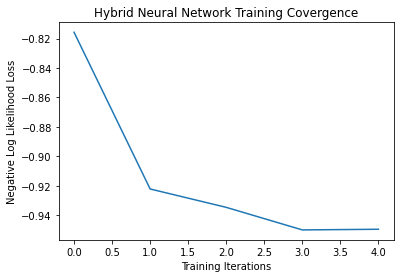

In [9]:
plt.plot(list_loss)

plt.title('Hybrid Neural Network Training Covergence')

plt.xlabel('Training Iterations')
plt.ylabel('Negative Log Likelihood Loss')


### Evaluation Loop.
Evaluation of the model. Yayyyy !!

In [10]:
model.eval()

with torch.no_grad():
    correct = 0
    for batch, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_fn(output, target)
        tl.append(loss.item())
        
    print(f'Accuracy: {correct/len(test_loader) * 100}')

Accuracy: 100.0


### That's all folks !

Try out with different quantum circuits and schemes. Maybe you'll come up with a better scheme and publish a paper out of it.  